In [1]:
!pip install git+https://github.com/VincentStimper/normalizing-flows.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-i50_b2tv
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-i50_b2tv
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-29eoutug/residual-flows_dbd00041a6f147c3a69868e0a8fa816d
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-29eoutug/residual-flows_dbd00041a6f147c3a69868e0a8fa816d
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=e99043458d908441a00b6d38b375bd55fb77862f9b12c7159e5ca263a6ed52a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-d36hzqco/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=58a79a

In [2]:
# Import basic libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from utils import *

# Import Normflow
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

# For saving and loading
import pickle
%matplotlib inline

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

# Normalizing Flow demo

In [ ]:
K = 10
beta = 1.0
#torch.manual_seed(0)

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

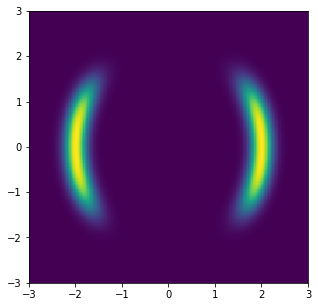

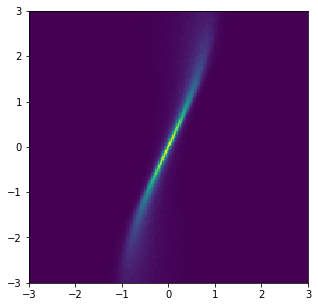

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(2), flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        z, log_q = self.q0(num_samples)
        #print(z)
        #print(log_q)
        for flow in self.flows:
            #print(flow(z))
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)


model = nfmodel(q0=nf.distributions.DiagGaussian(2), flows=flows, p=target).to(device)

 40%|███▉      | 1981/5000 [00:07<00:11, 266.66it/s]

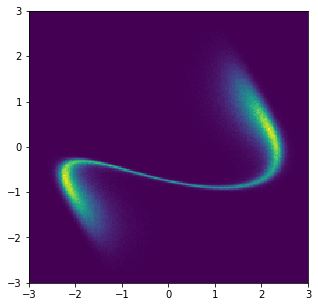

 80%|███████▉  | 3985/5000 [00:15<00:03, 260.74it/s]

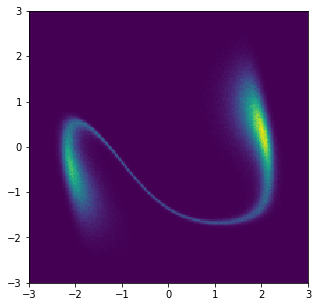

100%|██████████| 5000/5000 [00:19<00:00, 251.18it/s]


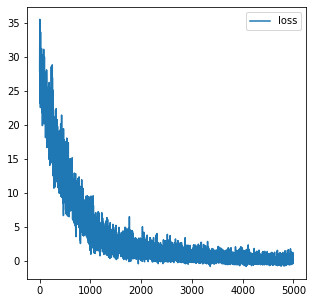

In [ ]:
# Train model
max_iter = 5000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = model.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

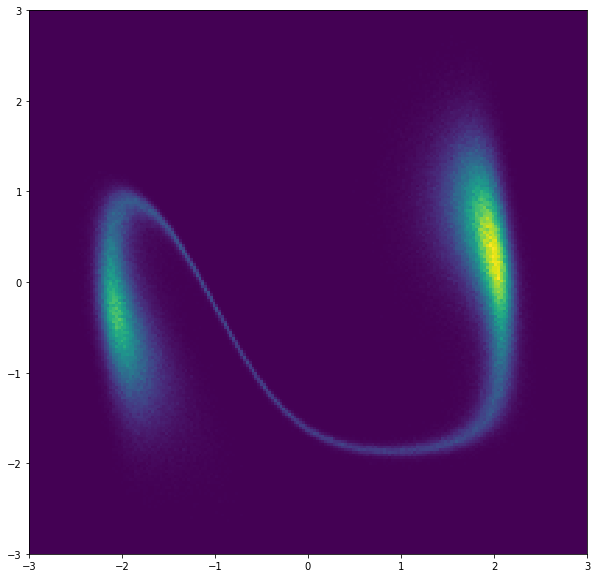

In [ ]:
# Plot learned posterior distribution
z, _ = model.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Utility functions regarding Cryo-EM

In [3]:
# Frequently used definitions
dtype = torch.FloatTensor
#enable_cuda = False
#device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

pdbfile = 'water.pdb' #'alanine-dipeptide.pdb'
num_atoms = 3 #22
forcefile = 'amber14/tip3pfb.xml' #'amber14-all.xml'

pklfile = 'water_img1024_dim25_nse1_blob0.001_q0.2.pkl' #'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 64 #1024
n_cells = 25 #51
noise_var = 1
blob_var = 0.001
Q = 0.2

num_flows = 5
beta = 10.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

2.4944309407680003


In [4]:
# testing

atm_crd = np.array([[-0.01907088,-0.03568486,0.02280679], [0.03153054,0.04458783,0.05792664], [0.01212991,-0.05448926,-0.07158886]])
print(potential(torch.tensor(atm_crd.flatten())))
atm_crd = np.array([[-0.0193,-0.0359,0.0220], [0.0319,0.0440,0.0570], [0.0128,-0.0549,-0.0666]])
print(potential(torch.tensor(atm_crd.flatten())))

atm_crd = np.array([[[-0.01907088,-0.03568486,0.02280679], [0.03153054,0.04458783,0.05792664], [0.01212991,-0.05448926,-0.07158886]],
                    [[-0.0193,-0.0359,0.0220], [0.0319,0.0440,0.0570], [0.0128,-0.0549,-0.0666]]])
print(potential_fast(torch.tensor(atm_crd)))

tensor(0.0288, dtype=torch.float64)
tensor(11.8249, dtype=torch.float64)
tensor([ 0.0288, 11.8249], dtype=torch.float64)


# Water Molecule Images

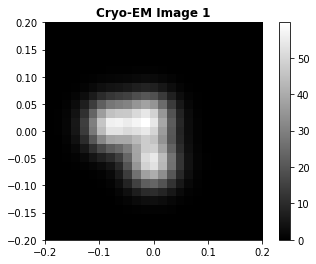

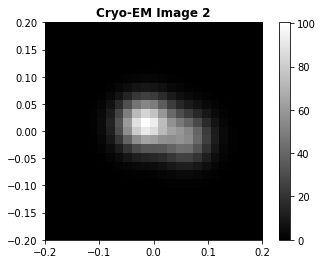

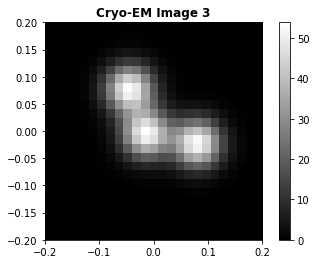

In [31]:
with open(pklfile, 'rb') as inp:
    rot_mats = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pot_energies = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    forces_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pos_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    redundant = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]

img_list = [torch_createblobs(pos_list[_], rot_mat=rot_mats[_]) for _ in range(num_imgs)]
plot_cryoem_imgs(img_list[:3])

# Gaussian Base

In [32]:
num_flows = 5
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

class nfmodel(nn.Module):
    def __init__(self, flows=flows):
        super().__init__()

        self.q0 = nf.distributions.DiagGaussian(num_atoms*3)
        self.flows = nn.ModuleList(flows)

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        z = z/100
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta=beta):
        z, _ = self.q0(num_samples)
        z = z/100
        log_q = 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            recon_img = torch_createblobs(molecule.reshape(3,3))
            imerr0 = torch.exp(-torch.norm(img_list[0]/100 - recon_img/100)**2/(2*noise_var))
            imerr1 = torch.exp(-torch.norm(img_list[1]/100 - recon_img/100)**2/(2*noise_var))
            log_imerr += torch.log(imerr0 + imerr1)
            #log_imerr += -torch.norm(target/100 - recon_img/100)**2/(2*noise_var)
            log_pot += -potential(molecule.flatten())

        return torch.mean(log_q) - (10000*log_imerr + beta * log_pot)/num_samples


model = nfmodel(flows=flows).to(device)

In [33]:
# Train model
max_iter = 1000
num_samples = 50
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
        
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 2/1000 [00:00<01:40,  9.92it/s]

65559.4


 10%|█         | 102/1000 [00:10<01:35,  9.40it/s]

4176.2466


 20%|██        | 202/1000 [00:20<01:23,  9.52it/s]

3070.6628


 30%|███       | 302/1000 [00:31<01:14,  9.39it/s]

2558.5095


 40%|████      | 402/1000 [00:41<00:59, 10.11it/s]

2403.2866


 50%|█████     | 502/1000 [00:52<00:51,  9.66it/s]

2331.0115


 60%|██████    | 602/1000 [01:03<00:41,  9.54it/s]

2247.379


 62%|██████▏   | 616/1000 [01:04<00:40,  9.52it/s]


KeyboardInterrupt: ignored

tensor(0.1104, grad_fn=<CopyBackwards>)
tensor(0.1039, grad_fn=<CopyBackwards>)
tensor(0.1619, grad_fn=<CopyBackwards>)
tensor(68.9490)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


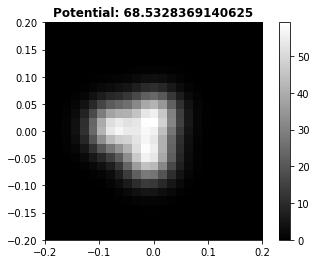

In [39]:
molecules, _ = model.sample(num_samples=1)

for molecule in molecules:
    atm_crd = molecule.reshape(3,3)
    print(torch.norm(atm_crd[0] - atm_crd[1]))
    print(torch.norm(atm_crd[0] - atm_crd[2]))
    print(torch.norm(atm_crd[1] - atm_crd[2]))

    img = torch_createblobs(molecule.reshape(3,3)).data
    c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    print(torch.norm(torch.tensor(img) - img_list[0]))
    plt.title(f'Potential: {potential(molecule.flatten())}', fontweight = "bold")
    plt.show()

# NF MD Simulated base distribution

In [40]:
'''
count = 1
loc = [img_list[i].flatten().numpy() for i in range(count)]
plot_cryoem_imgs([img.reshape(n_cells, n_cells) for img in torch.tensor(loc)])

print(loc[0].shape)

target = nf.distributions.GaussianMixture(count, n_cells**2, loc=loc, scale=list(np.ones((count, n_cells**2))), trainable=False)'''

'\ncount = 1\nloc = [img_list[i].flatten().numpy() for i in range(count)]\nplot_cryoem_imgs([img.reshape(n_cells, n_cells) for img in torch.tensor(loc)])\n\nprint(loc[0].shape)\n\ntarget = nf.distributions.GaussianMixture(count, n_cells**2, loc=loc, scale=list(np.ones((count, n_cells**2))), trainable=False)'

In [41]:
num_flows = 5
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,), u=torch.zeros(num_atoms*3), b=torch.zeros(1))]

class nfmodel(nn.Module):
    def __init__(self, flows=flows, p=target):
        super().__init__()

        self.q0 = torch.vstack([i.reshape(-1, num_atoms*3) for i in pos_list]) 
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        rand_idx = np.random.randint(low=count, high=len(pos_list), size=num_samples)
        z, log_q = self.q0[rand_idx], 0
        z = z/100

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        rand_idx = np.random.randint(low=count, high=len(pos_list), size=num_samples)
        z, log_q = self.q0[rand_idx], 0
        z = z/100

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            recon_img = torch_createblobs(molecule.reshape(3,3))
            imerr0 = torch.exp(-torch.norm(img_list[0]/100 - recon_img/100)**2/(2*10))
            imerr1 = torch.exp(-torch.norm(img_list[1]/100 - recon_img/100)**2/(2*10))
            log_imerr += torch.log(imerr0 + imerr1)
            #log_imerr += -torch.norm(target/100 - recon_img/100)**2/(2*noise_var)
            log_pot += -potential(molecule.flatten())

        return torch.mean(log_q) - (10000*log_imerr + log_pot)/num_samples


model0 = nfmodel(flows=flows, p=target).to(device)

In [42]:
# Train model
max_iter = 2500
num_samples = 50
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model0.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model0.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model0.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
        
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % int(max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 2/2500 [00:00<03:58, 10.46it/s]

7258.6265


 10%|█         | 252/2500 [00:25<03:48,  9.85it/s]

-5477.5347


 20%|██        | 502/2500 [00:51<03:34,  9.30it/s]

-5477.505


 27%|██▋       | 664/2500 [01:08<03:10,  9.63it/s]


KeyboardInterrupt: ignored

tensor([[ 0.0087, -0.0325, -0.0057],
        [-0.0608,  0.0105, -0.0679],
        [ 0.0023,  0.0294,  0.0766]], grad_fn=<ReshapeAliasBackward0>)
tensor(0.1027, grad_fn=<CopyBackwards>)
tensor(0.1032, grad_fn=<CopyBackwards>)
tensor(0.1588, grad_fn=<CopyBackwards>)


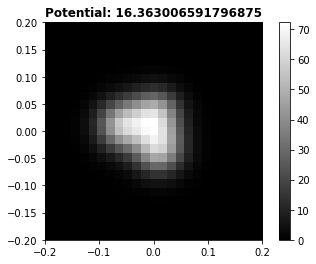

In [47]:
molecules, _ = model0.sample(num_samples=1)
molecule = torch.mean(molecules, dim = 0)

atm_crd = molecule.reshape(num_atoms,3) #- torch.mean(molecule.reshape(num_atoms,3), dim = 0)
print(atm_crd)
print(torch.norm(atm_crd[0] - atm_crd[1]))
print(torch.norm(atm_crd[0] - atm_crd[2]))
print(torch.norm(atm_crd[1] - atm_crd[2]))

img = torch_createblobs(atm_crd).data  #, rot_mat=rot_mats[idx]
c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                          extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)

#print(torch.norm(torch.tensor(img) - img_list[idx]))
plt.title(f'Potential: {potential(molecule.flatten())}', fontweight = "bold")
plt.show()